In [1]:
import numpy as np
import pandas as pd
from sklearn.svm import SVC, SVR
from sklearn.metrics import accuracy_score

## Load data

In [2]:
x_train = np.load("x_train.npy")
y_train = np.load("y_train.npy")
x_test = np.load("x_test.npy")
y_test = np.load("y_test.npy")

In [3]:
# 550 data with 300 features
print(x_train.shape)

(550, 300)


In [4]:
# It's a binary classification problem 
print(np.unique(y_train))

[0 1]


## Question 1
K-fold data partition: Implement the K-fold cross-validation function. Your function should take K as an argument and return a list of lists (len(list) should equal to K), which contains K elements. Each element is a list contains two parts, the first part contains the index of all training folds, e.g. Fold 2 to Fold 5 in split 1. The second part contains the index of validation fold, e.g. Fold 1 in  split 1

In [5]:
# import random
# seed = random.randrange(100000)
# np.random.seed(seed)
# print("Seed was:", seed)

def cross_validation(x_train, y_train, k=5):
    y_train = np.resize(y_train, (1,y_train.shape[0]))   # resize y train for append x and y.
    train = np.append(x_train, y_train.T, axis=1)          # append x and y together.
    np.random.seed(59527)
    train_rd = np.copy(train)                            # clone an array for shuttle.
    np.random.shuffle(train_rd)                          # shuffle the train array.
    kfold_data = []
    total_num = x_train.shape[0]                         # total number of training set.
    fold_num = int(total_num / k)                        # the number of dataset in a folder.
    for i in range(k):                                   # cut k part and store in to kfold_data
        valid_index = list(range(i*fold_num,(i+1)*fold_num))
        valid_data = train_rd[i*fold_num:(i+1)*fold_num]
        rest = np.delete(train_rd, valid_index, 0)
        kfold_data.append([rest, valid_data])
    return kfold_data

In [6]:
kfold_data = cross_validation(x_train, y_train, k=10)
assert len(kfold_data) == 10 # should contain 10 fold of data
assert len(kfold_data[0]) == 2 # each element should contain train fold and validation fold
assert kfold_data[0][1].shape[0] == 55 # The number of data in each validation fold should equal to training data divieded by K

## example

In [7]:
# from sklearn.model_selection import KFold

# X = np.arange(20)
# kf = KFold(n_splits=5, shuffle=True)
# kfold_data= []
# for i, (train_index, val_index) in enumerate(kf.split(X)):
#     print("Split: %s, Training index: %s, Validation index: %s" % (i+1, train_index, val_index))
#     kfold_data.append([train_index, val_index])

In [8]:
# assert len(kfold_data) == 5 # should contain 5 fold of data
# assert len(kfold_data[0]) == 2 # each element should contains index of training fold and validation fold
# assert kfold_data[0][1].shape[0] == 4 # The number of data in each validation fold should equal to training data divieded by K

## Question 2
Using sklearn.svm.SVC to train a classifier on the provided train set and conduct the grid search of “C” and “gamma” to find the best parameters by cross-validation.

In [9]:
# clf = SVC(C=1.0, kernel='rbf', gamma=0.01)

In [10]:
## your code
def gridsearch(kfold_data, C_list, gamma_list):
    best_score = 0
    grid_acc = []
    for C in C_list:
        gamma_acc = []
        for gamma in gamma_list:
            score_k = 0
            for k in range(len(kfold_data)):
                x_train_k = kfold_data[k][0][:,:-1]
                y_train_k = kfold_data[k][0][:,-1]
                x_valid_k = kfold_data[k][1][:,:-1]
                y_valid_k = kfold_data[k][1][:,-1]
                clf = SVC(C=C, kernel='rbf', gamma=gamma)
                clf.fit(x_train_k, y_train_k)
                score = clf.score(x_valid_k, y_valid_k)
                score_k += score
            score_final = score_k / len(kfold_data)
            gamma_acc.append(score_final)
            if score_final >= best_score:
                best_score = score_final
                best_parameters = [C, gamma]
        grid_acc.append(gamma_acc)
    grid_acc = np.asarray(grid_acc)
    return best_parameters, best_score, grid_acc

In [11]:
C_list = [0.01, 0.1, 1, 10, 100, 1000, 10000]
gamma_list = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
best_parameters, best_score, grid_acc = gridsearch(kfold_data, C_list, gamma_list)

In [12]:
print(best_score)
print(best_parameters)
print(grid_acc.shape)

0.8927272727272726
[100, 0.0001]
(7, 8)


## Question 3
Plot the grid search results of your SVM. The x, y represents the hyperparameters of “gamma” and “C”, respectively. And the color represents the average score of validation folds
You reults should be look like this reference image below ![image](https://miro.medium.com/max/1296/1*wGWTup9r4cVytB5MOnsjdQ.png) 

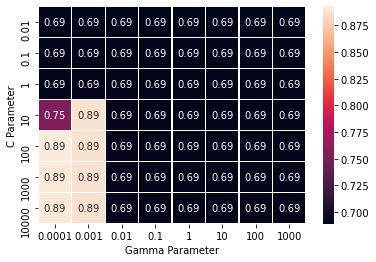

In [13]:
import seaborn as sns
import matplotlib.pylab as plt

ax = sns.heatmap(grid_acc, annot=True, xticklabels=gamma_list, yticklabels=C_list, linewidth=0.3)
ax.set(xlabel='Gamma Parameter', ylabel='C Parameter')
plt.show()

## Question 4
Train your SVM model by the best parameters you found from question 2 on the whole training set and evaluate the performance on the test set.

In [14]:
best_model = SVC(C=best_parameters[0], kernel='rbf', gamma=best_parameters[1])
best_model.fit(x_train, y_train)

SVC(C=100, gamma=0.0001)

In [15]:
y_pred = best_model.predict(x_test)
print("Accuracy score: ", accuracy_score(y_pred, y_test))

Accuracy score:  0.9010416666666666
